In [14]:
from torch.utils.data import random_split, DataLoader
from torchvision import datasets, transforms

# Define transformations for data preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to the input size of ViT (224x224)
    transforms.ToTensor(),  # Convert images to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize with ImageNet mean and std
])

# Load the full dataset
full_data = datasets.ImageFolder(r'C:\Users\SURENDHAN\Desktop\pro\colored_images', transform=transform)

# Split the dataset into training (80%) and validation (20%)
train_size = int(0.8 * len(full_data))
val_size = len(full_data) - train_size
train_data, val_data = random_split(full_data, [train_size, val_size])

# Create DataLoader for training and validation
train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
val_loader = DataLoader(val_data, batch_size=16, shuffle=False)


In [15]:
import torch
import torch.nn as nn
from transformers import ViTForImageClassification
import matplotlib.pyplot as plt
import random
from PIL import Image

# Load pretrained ViT model for image classification
model = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224-in21k", num_labels=5)

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_fe

In [16]:
# Define optimizer and loss function
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)
criterion = nn.CrossEntropyLoss()

# Tracking lists for loss and accuracy
train_losses = []
train_accuracies = []
val_accuracies = []


In [17]:
# Training loop
epochs = 5

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        # Forward pass
        outputs = model(images).logits
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Statistics
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = 100 * correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)

    print(f"Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%")


Epoch [1/5], Loss: 0.9795, Accuracy: 67.00%
Epoch [2/5], Loss: 0.6839, Accuracy: 76.33%
Epoch [3/5], Loss: 0.5760, Accuracy: 81.12%
Epoch [4/5], Loss: 0.4927, Accuracy: 84.13%
Epoch [5/5], Loss: 0.4292, Accuracy: 86.97%


In [18]:
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm  # For progress bar visualization

# Assuming model, val_loader, and device are defined
model.eval()  # Set model to evaluation mode
val_accuracies = []  # To store validation accuracies over epochs
correct = 0
total = 0

# Validation loop
with torch.no_grad():  # No gradient computation
    for images, labels in tqdm(val_loader, desc="Validating"):
        # Send data to device (GPU/CPU)
        images, labels = images.to(device), labels.to(device)
        
        # Forward pass
        outputs = model(images)
        logits = outputs.logits if hasattr(outputs, 'logits') else outputs  # Handle cases without logits
        _, predicted = torch.max(logits, 1)  # Get class with highest probability
        
        # Update metrics
        total += labels.size(0)  # Total number of samples
        correct += (predicted == labels).sum().item()  # Correct predictions

# Compute accuracy
val_accuracy = 100 * correct / total
val_accuracies.append(val_accuracy)  # Store for tracking
print(f"Validation Accuracy: {val_accuracy:.2f}%")


Validating: 100%|██████████| 46/46 [01:34<00:00,  2.06s/it]

Validation Accuracy: 80.87%


In [19]:
print(f"Train Losses: {train_losses}")
print(f"Train Accuracies: {train_accuracies}")
print(f"Validation Accuracies: {val_accuracies}")

Train Losses: [0.9795327585577314, 0.6839472265517126, 0.5760480917868067, 0.4926599540589937, 0.42924052998016443]
Train Accuracies: [66.99726402188783, 76.33378932968536, 81.1217510259918, 84.1313269493844, 86.96990424076607]
Validation Accuracies: [80.8743169398907]


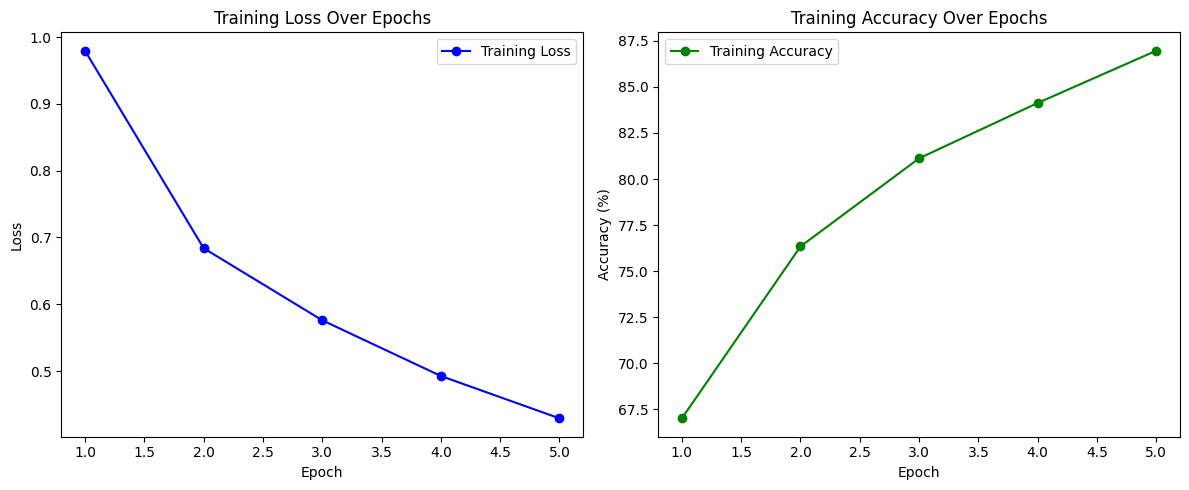

In [21]:
# Plotting the training statistics (Loss and Accuracy)
plt.figure(figsize=(12, 5))

# Plot training loss
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), train_losses, label='Training Loss', color='blue', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()

# Plot training accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), train_accuracies, label='Training Accuracy', color='green', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training Accuracy Over Epochs')
plt.legend()

# Adjust layout and display the plots
plt.tight_layout()
plt.show()


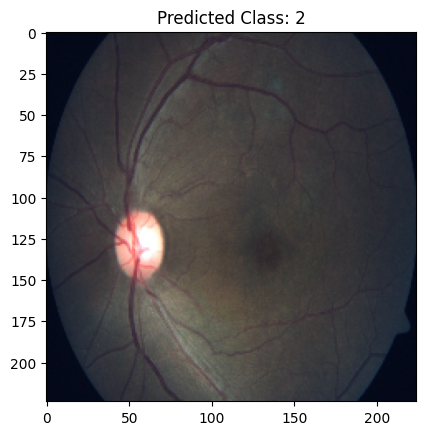

Actual Label: 2


In [22]:
# Predicting a random image from the validation set
model.eval()  # Set model to evaluation mode

# Get a random image from the validation set
random_idx = random.randint(0, len(val_data) - 1)
img, label = val_data[random_idx]

# Convert the image to the expected format
img = img.unsqueeze(0).to(device)

# Get model prediction
with torch.no_grad():
    outputs = model(img).logits
    _, predicted_class = torch.max(outputs, 1)

# Show the image and print the prediction
img = img.squeeze().cpu().numpy().transpose(1, 2, 0)  # Convert to HWC for display
img = (img * 0.229 + 0.485)  # Denormalize (assuming ImageNet normalization)
img = img.clip(0, 1)

# Plot the image
plt.imshow(img)
plt.title(f"Predicted Class: {predicted_class.item()}")
plt.show()

# Print the actual label
print(f"Actual Label: {label}")


In [23]:
import torch

# Specify the file name for saving the model
model_save_path = "diabetic_retinopathy_model.pth"

# Save the model's state dictionary
torch.save(model.state_dict(), model_save_path)

print(f"Model saved successfully to {model_save_path}")


Model saved successfully to diabetic_retinopathy_model.pth
